In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
data = "C:/Users/vyshn/OneDrive/Desktop/dog_v1"
data = pathlib.Path(data)
#The Path object can be used to perform various file and directory operations,
#such as checking if the file/directory exists, deleting a file/directory,
#getting the file size, iterating over the files in a directory, etc.
#Basically access the directory.

In [4]:
image_count = len(list(data.glob('*/*.jpg')))
print(image_count)
#The glob method returns an iterator that yields Path objects that represent each matching file.
#'*/ *.jpg'. This pattern matches all files with the extension .jpg
#in all subdirectories of the directory referenced by data

880


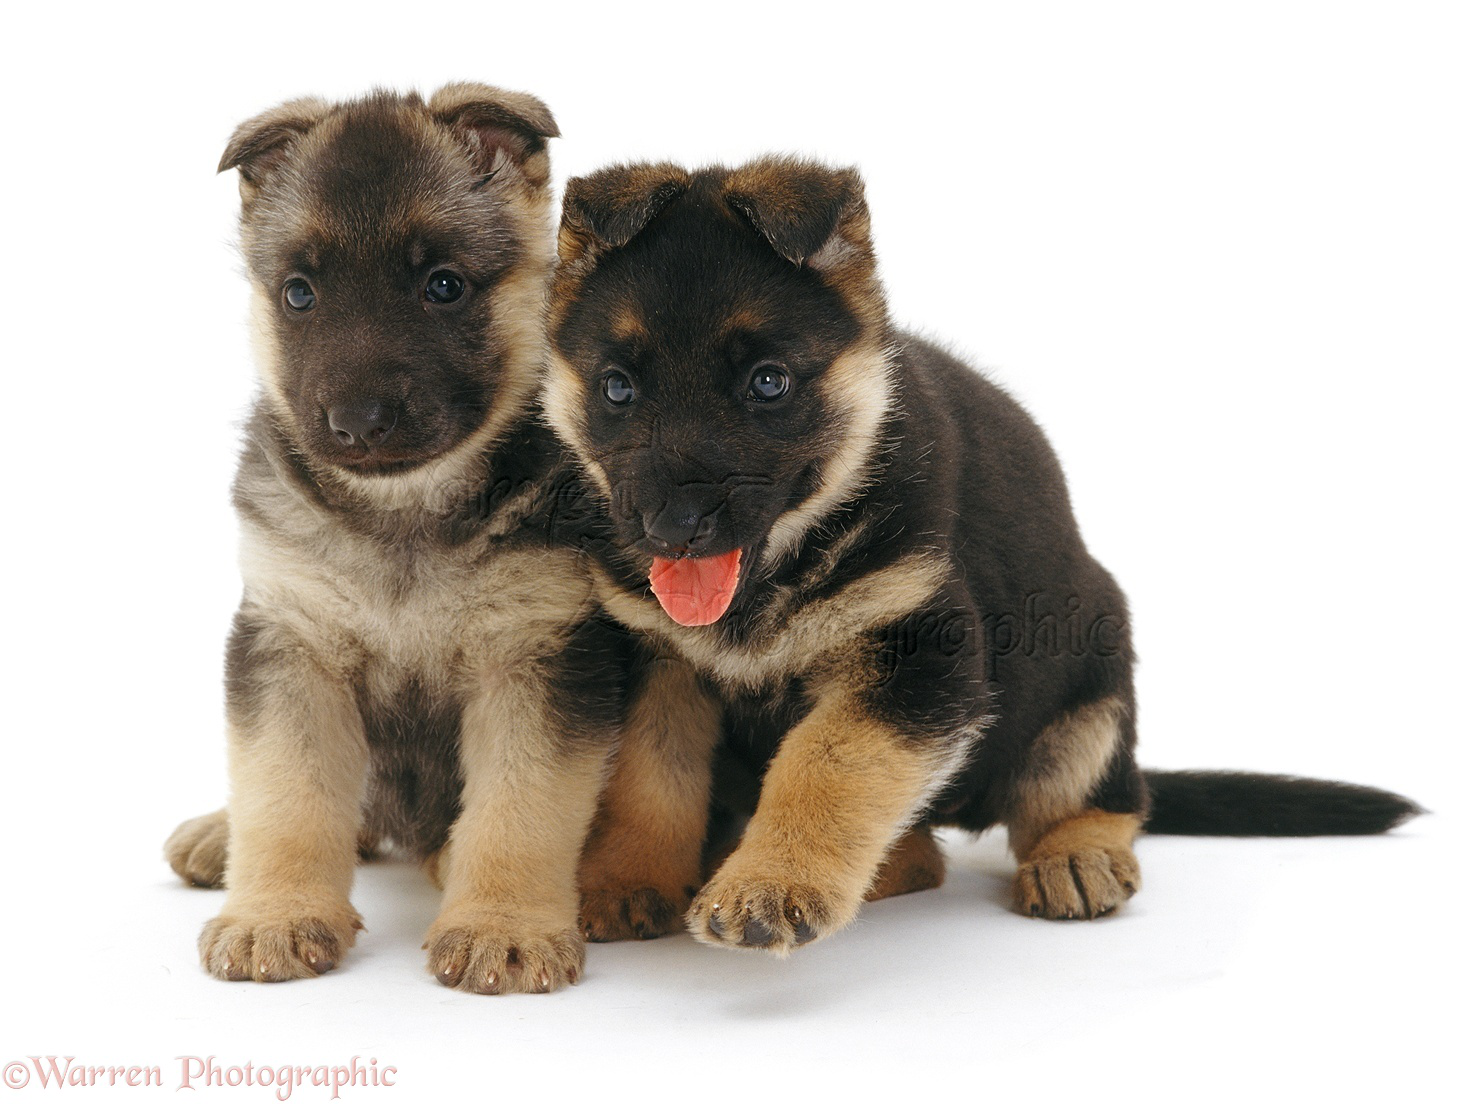

In [5]:
gs = list(data.glob('german_shepherd/*'))
PIL.Image.open(str(gs[0]))
#PIL is Python Imaging Library
#The str() function is used to convert the file path from a Path object to a string.

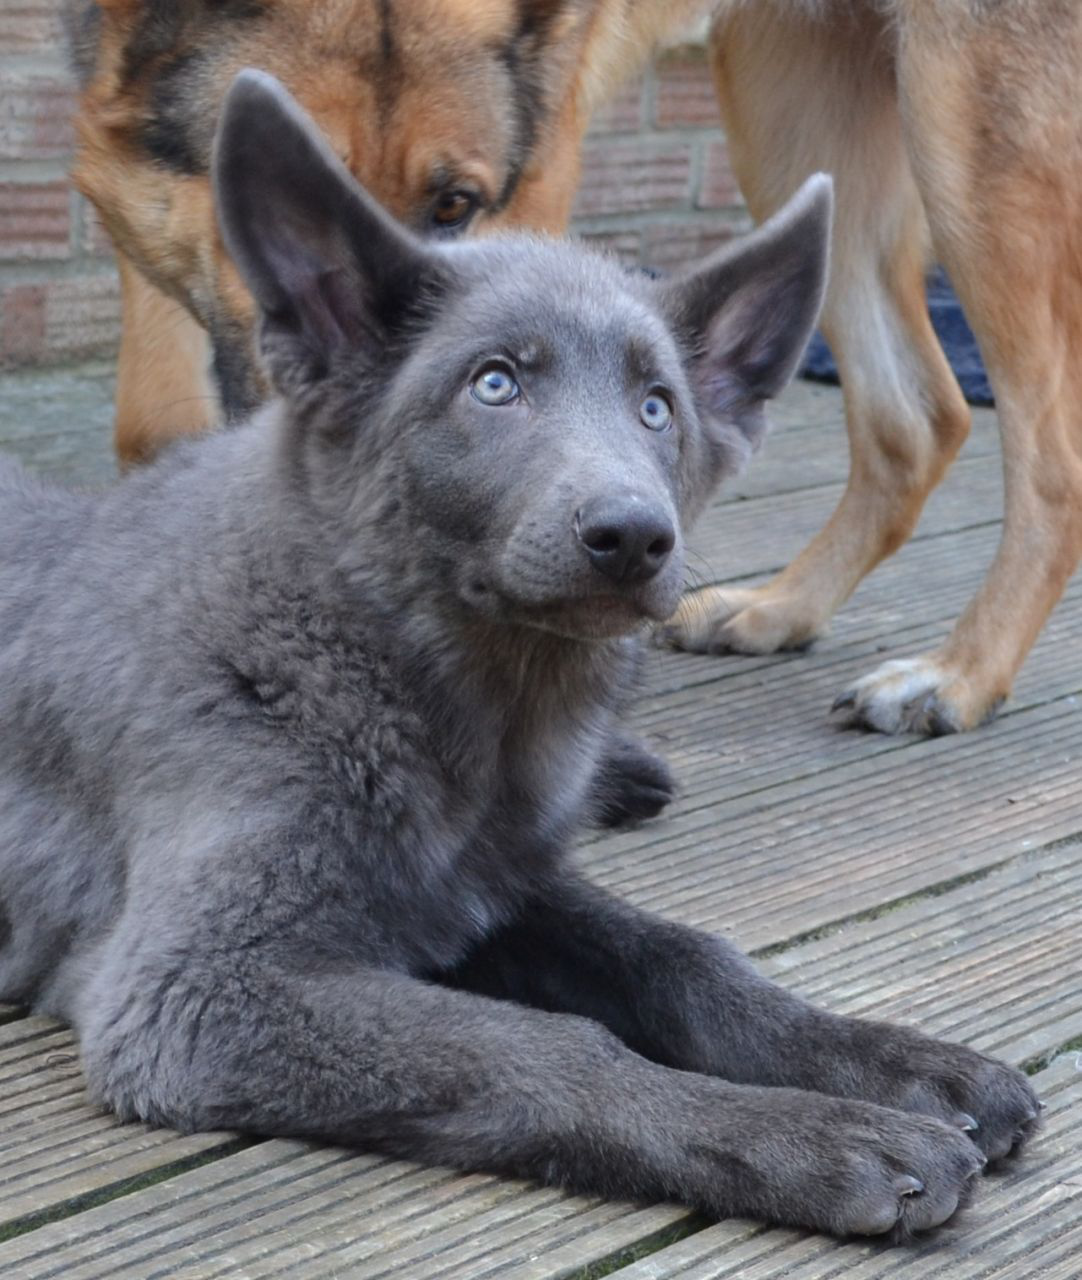

In [6]:
PIL.Image.open(str(gs[1]))

In [7]:
batch_size = 32
#batch_size is set to 32, which means that the model will
#process 32 images at a time during training or inference.
img_height = 180
img_width = 180
#180 pixels

In [8]:
train = tf.keras.utils.image_dataset_from_directory(
    data,
    validation_split = 0.2,
    subset='training',
    seed = 123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 1030 files belonging to 5 classes.
Using 824 files for training.


In [9]:
val = tf.keras.utils.image_dataset_from_directory(
    data,
    validation_split = 0.2,
    subset='validation',
    seed = 123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 1030 files belonging to 5 classes.
Using 206 files for validation.


In [11]:
class_names = train.class_names
print(class_names)

['french_bulldog', 'german_shepherd', 'golden_retriever', 'poodle', 'yorkshire_terrier']


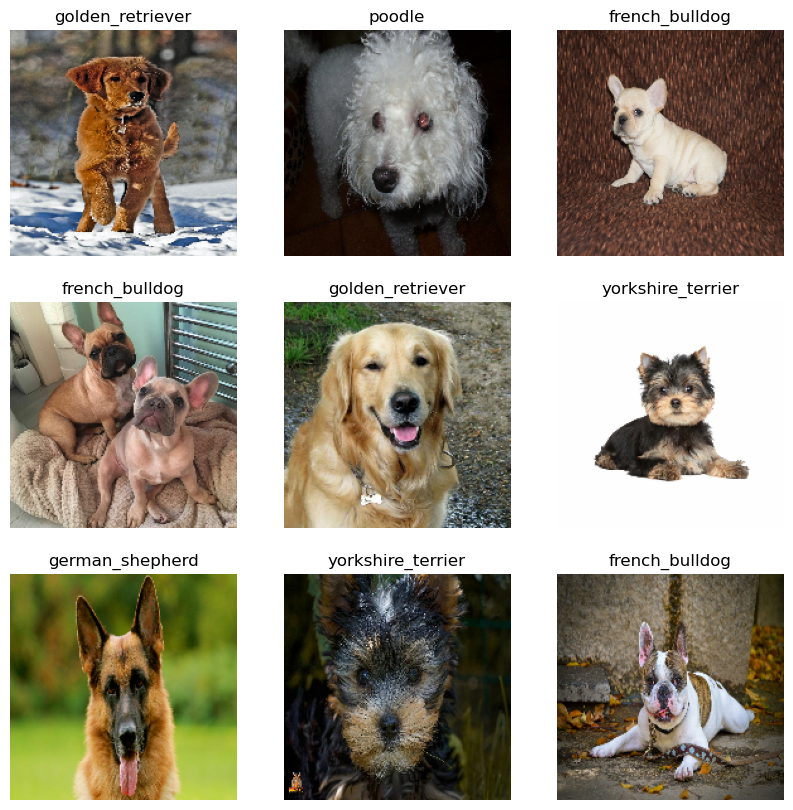

In [12]:
plt.figure(figsize=(10,10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [13]:
for image_batch, labels_batch in train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)
#train.cache() is used to cache the training data in memory or on disk,
#which can speed up training by avoiding the need to read the data from disk repeatedly.

#train.shuffle(1000) shuffles the training data with a buffer size of 1000,
#which can improve the model's performance by preventing it from overfitting
#to the order of the training examples.

In [15]:
normalization_layer = layers.Rescaling(1./255)
#This rescaling is typically applied to image data before feeding it
#into a neural network model, as the pixel values in images
#are usually represented as integers between 0 and 255.

#By applying this normalization layer to the input data, the neural network model
#can more easily learn the underlying patterns in the data without being affected by variations
#in the pixel values due to differences in lighting, exposure, or other factors.

In [16]:
normalized = train.map(lambda x, y: (normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalized))
first_image = image_batch[0]
print(np.min(first_image),np.max(first_image))

0.0 1.0


In [17]:
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
#Tough Explanation
#Overall, this model is a simple Convolutional Neural Network (CNN) that consists
#of several convolutional layers followed by fully connected layers.
#The purpose of this model is likely to classify images into one
#of the num_classes categories based on the features extracted from the convolutional layers.

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#In this case, the Adam optimizer is used, which is a popular optimization algorithm
#for training deep learning models.

In [19]:
model.summary()
# In this case, the Sparse Categorical Crossentropy loss function is used,
#which is commonly used for multi-class classification problems where the ground-truth
#labels are integers.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [20]:
epochs=10
history = model.fit(
  train,
  validation_data=val,
  epochs=epochs
)
#The validation_data argument specifies the validation dataset to use for evaluating
#the performance of the model after each epoch of training.

#The epochs argument specifies the number of epochs (i.e., complete passes through the training data)
#to train the model for.

Epoch 1/10
26/26 [==============================] - 22s 781ms/step - loss: 1.7518 - accuracy: 0.2269 - val_loss: 1.5944 - val_accuracy: 0.2573
Epoch 2/10
26/26 [==============================] - 14s 542ms/step - loss: 1.5748 - accuracy: 0.2743 - val_loss: 1.5042 - val_accuracy: 0.3058
Epoch 3/10
26/26 [==============================] - 14s 551ms/step - loss: 1.4290 - accuracy: 0.4102 - val_loss: 1.3735 - val_accuracy: 0.4078
Epoch 4/10
26/26 [==============================] - 15s 583ms/step - loss: 1.2201 - accuracy: 0.5121 - val_loss: 1.3737 - val_accuracy: 0.4612
Epoch 5/10
26/26 [==============================] - 15s 561ms/step - loss: 1.0044 - accuracy: 0.6347 - val_loss: 1.3068 - val_accuracy: 0.4951
Epoch 6/10
26/26 [==============================] - 14s 558ms/step - loss: 0.7466 - accuracy: 0.7354 - val_loss: 1.5253 - val_accuracy: 0.4369
Epoch 7/10
26/26 [==============================] - 14s 542ms/step - loss: 0.5588 - accuracy: 0.8155 - val_loss: 1.6776 - val_accuracy: 0.4563

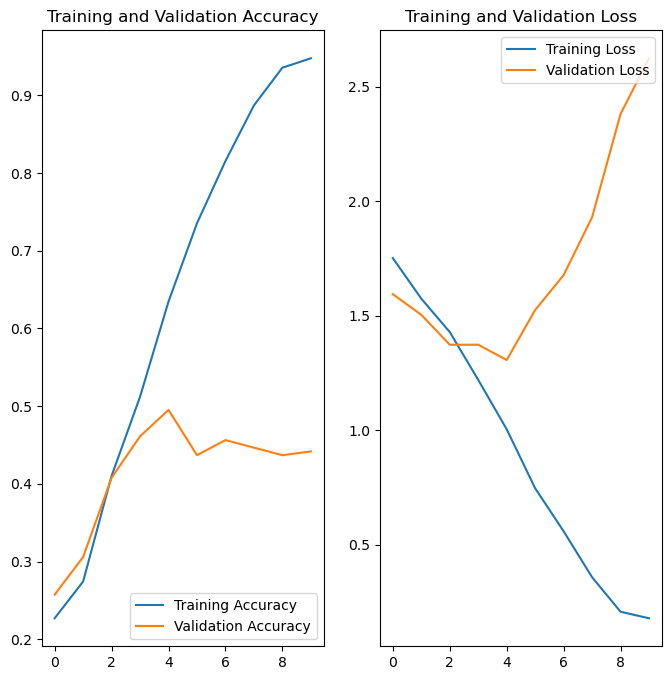

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
#Training set was 80% so better results than Valdiation which was 20%

In [22]:
test_url = "https://i.pinimg.com/originals/10/d7/75/10d775b05c5c4251f1ea02dab4cda35c.jpg"
test_path = tf.keras.utils.get_file('golden_retriever', origin=test_url)

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))

1/1 [==============================] - 0s 252ms/step
This image most likely belongs to german_shepherd with a 58.54 percent confidence.


In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

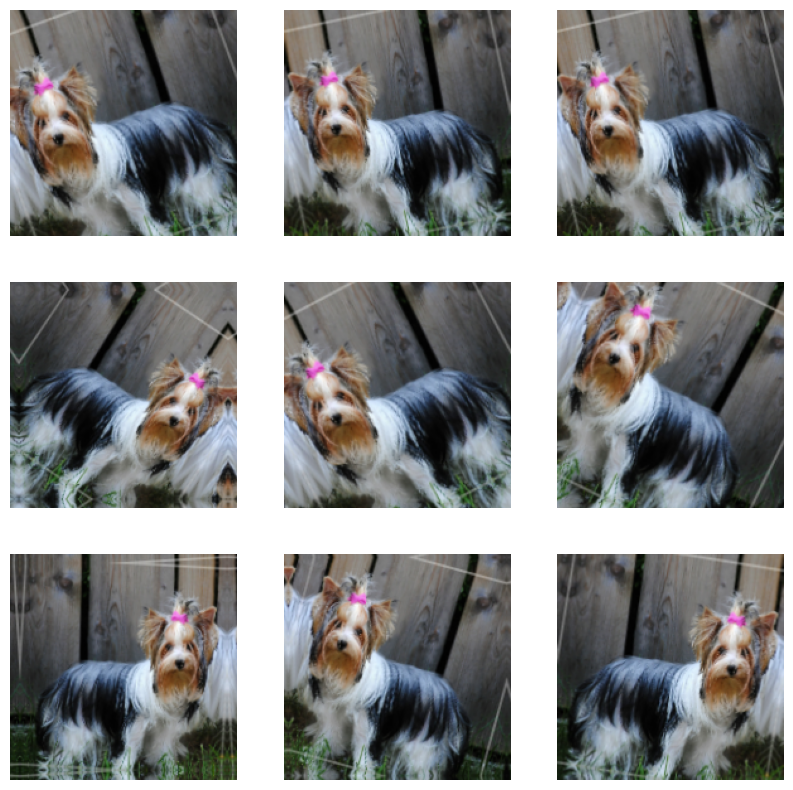

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [25]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [28]:
epochs = 15
history = model.fit(
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/15
26/26 [==============================] - 20s 691ms/step - loss: 1.7737 - accuracy: 0.1990 - val_loss: 1.6016 - val_accuracy: 0.2573
Epoch 2/15
26/26 [==============================] - 17s 654ms/step - loss: 1.6036 - accuracy: 0.2621 - val_loss: 1.5823 - val_accuracy: 0.2573
Epoch 3/15
26/26 [==============================] - 18s 700ms/step - loss: 1.5751 - accuracy: 0.3034 - val_loss: 1.5136 - val_accuracy: 0.3301
Epoch 4/15
26/26 [==============================] - 17s 636ms/step - loss: 1.4956 - accuracy: 0.3459 - val_loss: 1.4036 - val_accuracy: 0.4126
Epoch 5/15
26/26 [==============================] - 16s 605ms/step - loss: 1.4452 - accuracy: 0.3471 - val_loss: 1.3814 - val_accuracy: 0.4417
Epoch 6/15
26/26 [==============================] - 16s 607ms/step - loss: 1.3968 - accuracy: 0.3799 - val_loss: 1.3623 - val_accuracy: 0.3981
Epoch 7/15
26/26 [==============================] - 16s 607ms/step - loss: 1.3790 - accuracy: 0.4053 - val_loss: 1.4698 - val_accuracy: 0.2670

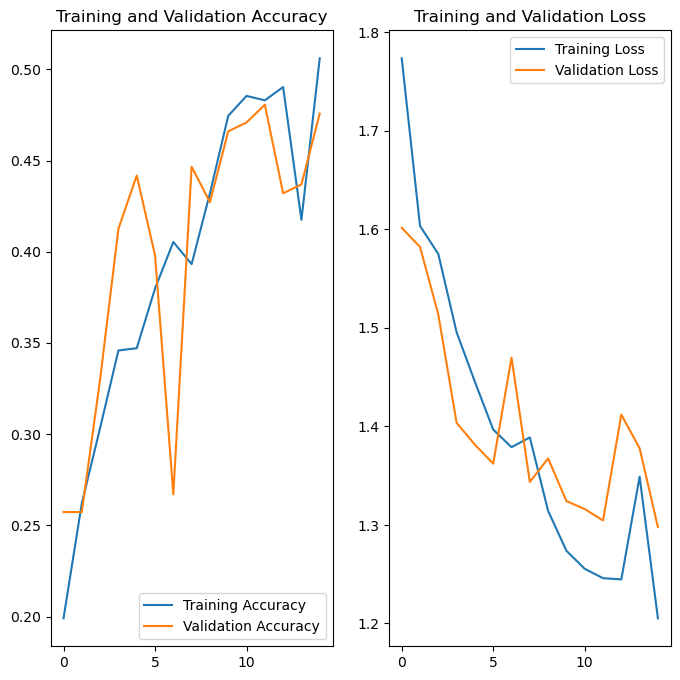

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
test_url = "https://i.pinimg.com/originals/10/d7/75/10d775b05c5c4251f1ea02dab4cda35c.jpg"
test_path = tf.keras.utils.get_file('golden_retriever', origin=test_url)

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 139ms/step
This image most likely belongs to poodle with a 49.00 percent confidence.
